In [1]:
from functions import *
from functions_new import *

import numpy as np
import os 

import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle

import seaborn as sns
from seaborn import heatmap
from seaborn import kdeplot

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.signal import savgol_filter

import SOAPify
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow, getSOAPSettings
import SOAPify.HDF5er as HDF5er

from MDAnalysis import Universe as mdaUniverse
from MDAnalysis import transformations
from MDAnalysis.tests.datafiles import TPR, XTC
from SOAPify.HDF5er import MDA2HDF5
from os import path
import hdbscan

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

/home/cristina/programs/SOAPify/latest_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
XYZ_DIR = 'INPUT_files/Water/'
XYZ_OUTDIR = 'Water/'
NAME = 'coexistence_95_98k' # NAME.hdf5
# old_name_hdf5 = False  # if OLD hdf5 file already exists (created using OLD name for GROUP)
# OLD_NAME = "run_nopbc_eq"
# OLD_GROUP = "/Trajectories/"+OLD_NAME
GROUP = "/Trajectories/"+NAME
MASK = False #be sure that mask used to create .hdf5 is the same used here

LOAD_HDF5 = True
LOAD_HDF5SOAP = True
LOAD_SOAP = True
LOAD_TimeSOAP = True
LOAD_LENS = True
dt = 1

TRJ_filename = NAME + ".xtc"  # or .lammpsdump 
TOP_filename = topo = NAME + ".gro"  # or .data

XYZ_ORIG = [0, 0, 0]
COFF=6  #be sure that is the same coff used to create soaps and lenses
window_length=200
polyorder = 2
wantedTrajectory = slice(0, None, None)
wantedUniverseAtoms = "type O"
# INIT=0
# END=500
# STRIDE=1

eq=0

SOAPnmax = 8
SOAPlmax = 8
SOAPatomMask = "O"

## Create HDF5 File from TOP and TRJ files

In [3]:
if LOAD_HDF5:
    
    if MASK:
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    
else:
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    createHDF5(TRJ_filename, TOP_filename, wantedUniverseAtoms)  # Create HDF5 File (if not present)
    os.chdir(mycwd)
    HDF5_TRJ  = NAME + ".hdf5"
    with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
        tgroup = trajFile[GROUP]
        universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
    
    if MASK:  # TODO: change HDF5 filename in mask.hdf5
        HDF5_TRJ  = NAME + "mask.hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
            
    else:
        HDF5_TRJ  = NAME + ".hdf5"
        HDF5_TRJ_nomask  = NAME + ".hdf5"
        with h5py.File(XYZ_DIR + HDF5_TRJ, "r") as trajFile:
            tgroup = trajFile[GROUP]
            universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)

In [4]:
nAtoms = len(universe.atoms)
windowToUSE = slice(eq+window_length // 2, -(window_length // 2))  # checked for both EVEN and ODD windows
windowToUSE_last = slice(eq+window_length // 2, -(window_length // 2+1))

In [5]:
print(windowToUSE)
print(windowToUSE_last)

slice(100, -100, None)
slice(100, -101, None)


## Create HDF5SOAP File

In [6]:
if LOAD_SOAP:
    pass

else:
    
    mycwd = os.getcwd()
    os.chdir(XYZ_DIR)
    prepareSOAP(HDF5_TRJ_nomask, NAME, COFF, SOAPnmax, SOAPlmax, SOAPatomMask)
    os.chdir(mycwd)

# 1. TimeSOAP

## Read TimeSOAP input

In [7]:
if LOAD_TimeSOAP:
    tsoap = np.load(XYZ_DIR+'time_dSOAP.npz')['name1']
    print(np.shape(tsoap))
else:

    if MASK:
        with h5py.File(XYZ_DIR+NAME+'.hdf5', 'r') as f:
            mask = f[GROUP+"Trajectory"][0, :, 2] > 12
        
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:][:, mask]
        
    else: 
        with h5py.File(XYZ_DIR+NAME+'soap.hdf5', 'r') as f:
            ds = f["SOAP/"+NAME]
            fillSettings = getSOAPSettings(ds)
            X = ds[:, :, :]

    X = SOAPify.fillSOAPVectorFromdscribe(
            X[:], **fillSettings)
        

    X = SOAPify.normalizeArray(X)
    np.savez(XYZ_DIR+'X_normalized.npz', name1=X)
    
    v_soap = np.load(XYZ_DIR+'X_normalized.npz')['name1'][windowToUSE]
    print(np.shape(v_soap))
    
    nAtoms, tsoap, dtSOAP = getTimeSOAP(XYZ_DIR+NAME+'soap.hdf5', NAME)   

(3000, 2048)


In [8]:
np.save(XYZ_DIR+"tsoap", tsoap)

In [9]:
nAtoms = np.shape(tsoap)[1]

In [10]:
tsoap_fl = np.array(tsoap).reshape(np.shape(tsoap)[0]*np.shape(tsoap)[1])
np.shape(tsoap_fl)

(6144000,)

## Filtering

In [11]:
tSOAP_rolling = moving_average(np.array(tsoap).T, window_length)
min = np.min(tSOAP_rolling)
print(min)
max = np.max(tSOAP_rolling)
print(max)
tSOAP_rolling_norm = (tSOAP_rolling-min)/(max-min)  # NORMALIZATION
tr_tSOAP_rolling = np.array(tSOAP_rolling_norm).T
fl_tSOAP_rolling = np.reshape(tr_tSOAP_rolling, np.shape(tr_tSOAP_rolling)[0]*np.shape(tr_tSOAP_rolling)[1])

0.024154076323550277
0.05977739218030588


In [12]:
dataToFit = transposeAndFlatten(tSOAP_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


In [13]:
savGolPrint = np.arange(tSOAP_rolling_norm.shape[1])

In [14]:
time = np.arange(savGolPrint[0]+window_length // 2 + 1, savGolPrint[-1]+window_length // 2 + 2 )
xticks = np.array(list(filter(lambda x: (x % 100 == 0), time)))

In [15]:
time

array([ 101,  102,  103, ..., 2899, 2900, 2901])

# 2. LENS

### Lens descriptor and filtering

In [16]:
if LOAD_LENS:
    LENS = np.load(XYZ_DIR+'lens.npy')
else:
    neigCounts = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF)
    LENS, nn, *_ = SOAPify.analysis.neighbourChangeInTime(neigCounts)
    np.save(XYZ_DIR+"lens", LENS)

In [17]:
LENS.shape

(2048, 3001)

In [18]:
# Remove the first frame (=0.0)
LENS = LENS[:, dt:]

In [19]:
len(LENS[0])

3000

In [20]:
atom = nAtoms - 1

In [21]:
LENS_rolling = moving_average(LENS, window_length)
min = np.min(LENS_rolling)
print(min)
max = np.max(LENS_rolling)
print(max)
LENS_rolling_norm = (LENS_rolling-min)/(max-min)  # NORMALIZATION
tr_LENS_rolling = np.array(LENS_rolling_norm).T
fl_LENS_rolling = np.reshape(tr_LENS_rolling, np.shape(tr_LENS_rolling)[0]*np.shape(tr_LENS_rolling)[1])

0.019158744209299146
0.1515710805567665


In [22]:
savGolPrint = np.arange(LENS_rolling_norm.shape[1])

In [23]:
LENS_rolling.shape

(2048, 2801)

In [24]:
dataToFit = transposeAndFlatten(LENS_rolling_norm)
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  0.0 1.0


# 3. (LENS-TimeSOAP) LEAP descriptor

## 3.1 Stack descriptors and reshape

In [25]:
djoint_d = np.dstack((np.transpose(tSOAP_rolling_norm),np.transpose(LENS_rolling_norm)))

In [26]:
djoint_d_fl = np.array(djoint_d).reshape(np.shape(djoint_d)[0]*np.shape(djoint_d)[1],np.shape(djoint_d)[2])

In [27]:
djoint_d_fl.shape

(5736448, 2)

In [28]:
LEAP = []

for i in range(0, len(djoint_d_fl)):
    leap = np.sqrt(djoint_d_fl[i, 1]**2+djoint_d_fl[i, 0]**2)
    
    LEAP.append(leap)

In [29]:
ts_LEAP = np.array(LEAP).reshape(LENS_rolling_norm.shape[1], LENS_rolling_norm.shape[0])

In [30]:
ts_LEAP = ts_LEAP.transpose()

In [31]:
# TRJ to draw on to the scatter plot
all_trj = []
for particle in range(0, np.shape(djoint_d)[1]):
    trj = djoint_d[:, particle, :]
    all_trj.append(trj)

## 3.3 2D Onion Clustering

In [33]:
signal_x = []
signal_y = []
clusters_j = []

with open(XYZ_DIR+'signal_with_labels.dat', 'r') as f:
    lines = f.readlines()
    
    for idx, line in enumerate(lines[1:]):
        row = line.split()
        signal_x.append(float(row[0]))
        signal_y.append(float(row[1]))
        clusters_j.append(int(row[2]))

In [34]:
x_dim = len(signal_x)
y_dim = len(signal_y)

In [35]:
signal_joint_fl = np.empty((x_dim, 2))

for i in range(0, x_dim):
    signal_joint_fl[i][0] = signal_x[i]
    signal_joint_fl[i][1] = signal_y[i] 

In [36]:
OnionCL_len = int(signal_joint_fl.shape[0]/djoint_d.shape[1])  #Get the length of data AFTER ONION clustering

In [37]:
OnionCL_len

2750

In [38]:
djoint_dCUT = np.dstack((np.transpose(tSOAP_rolling_norm[:, 0:OnionCL_len]),np.transpose(LENS_rolling_norm[:, 0:OnionCL_len])))

In [39]:
djoint_dCUT.shape

(2750, 2048, 2)

In [40]:
diffCUT = djoint_d.shape[0] - OnionCL_len
windowToUSE_CUT = slice(eq+window_length // 2, -(window_length // 2+diffCUT))

## 1D Onion Clustering

In [ ]:
# Thresholds from Onion_Clustering/Water/1D-tsoap/final_thresholds.txt
tSOAP_COFF = [0]+[0.26, 0.43, 0.46]+[1.1]

In [ ]:
# Thresholds from Onion_Clustering/Water/1D-lens/final_thresholds.txt
LENS_COFF = [0]+[0.21, 0.42, 0.57]+[1.1]

In [ ]:
palette_tSOAP = ['white', 'lightcyan', 'lightblue', 'blue']
palette_tSOAP = sns.color_palette(palette_tSOAP)
palette_tSOAP

In [ ]:
palette_LENS = ['white', 'mistyrose', 'lightsalmon', 'red']
palette_LENS = sns.color_palette(palette_LENS)
palette_LENS

In [ ]:
vfig, (ax, ax3) = plt.subplots(1, 2,figsize=(9,4), width_ratios=[4, 1], dpi=500)

plt.rcParams['axes.linewidth'] = 1
ax.tick_params(top=False,
               bottom=True,
               left=True,
               right=False, length=3, labelsize=20)

ax.set_xlabel(r't [$ns$]', weight='bold', size=25)

particle = [i for i in range(0, tSOAP_rolling_norm.shape[0])]
for p in particle:
    ax.plot(
        time,
        tSOAP_rolling_norm[p],
        color="black",
        linewidth=0.01,
        alpha=0.8,
    )
    
ax.plot(
        time,
        tSOAP_rolling_norm[595],
        color="blue",
        linewidth=2,
        alpha=0.8,
    )
    
ax.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
ax.set_xlabel(r't [ns]', size=20)
ax.set_xticks([500, 1500, 2500])
ax.set_xticklabels([0.5, 1.5, 2.5], fontsize=20)

ax.set_ylabel(r'$\tau$SOAP', weight='bold', size=25)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,0.5,1], fontsize=20)
ax.set_ylim((0,1))

    
hist = ax3.hist(np.array(djoint_d_fl[:, 0]), alpha=0.4, color='gray', bins=100, orientation=u'horizontal')

ax3.set_yticklabels([], size=20)
ax3.set_yticks([], [])
ax3.set_ylim(0, 1)

ax3.set_xlabel("# [x$10^5$]", size=20)
ax3.set_xticks([0,1e5])              
ax3.set_xticklabels([0,1], size=20) 

ax3.tick_params(top=False,
               bottom=True,
               left=False,
               right=False, length=3, labelsize=20)

ax2 = ax3.twiny()
my_kde = sns.kdeplot(y=np.array(djoint_d_fl[:, 0]), bw_adjust=0.7, linewidth=1.5, color='black', gridsize=500, ax=ax2, fill=True)
y = my_kde.collections[0].get_paths()[0]
v = y.vertices
lx = [v[r][0] for r in range(len(v))]
ly = [v[r][1] for r in range(len(v))]

ax2.set_xlabel("KDE", size=20)
ax2.set_xticklabels([], size=20)
ax2.set_xticks([], [])


ax.yaxis.get_offset_text().set_fontsize(20)


plt.subplots_adjust(wspace=0.15)
plt.savefig(XYZ_OUTDIR+'Figure/tSOAP_wdistribution.png', bbox_inches='tight')

In [ ]:
fig, (ax, ax3) = plt.subplots(1, 2,figsize=(9,4), width_ratios=[4, 1], dpi=500)

plt.rcParams['axes.linewidth'] = 1
ax.tick_params(top=False,
               bottom=True,
               left=True,
               right=False, length=3, labelsize=20)

ax.set_xlabel(r't [$ns$]', weight='bold', size=25)

particle = [i for i in range(0, tSOAP_rolling_norm.shape[0])]
for p in particle:
    ax.plot(
        time,
        LENS_rolling_norm[p],
        color="black",
        linewidth=0.01,
        alpha=0.8,
    )
    
ax.plot(
        time,
        LENS_rolling_norm[595],
        color="red",
        linewidth=2,
        alpha=0.8,
    )
    
ax.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
ax.set_xlabel(r't [ns]', size=20)
ax.set_xticks([500, 1500, 2500])
ax.set_xticklabels([0.5, 1.5, 2.5], fontsize=20)

ax.set_ylabel(r'LENS', weight='bold', size=25)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,0.5,1], fontsize=20)
ax.set_ylim((0,1))

    
hist = ax3.hist(np.array(djoint_d_fl[:, 1]), alpha=0.4, color='gray', bins=100, orientation=u'horizontal')

ax3.set_yticklabels([], size=20)
ax3.set_yticks([], [])
ax3.set_ylim(0, 1)

ax3.set_xlabel("# [x$10^5$]", size=20)
ax3.set_xticks([0,1e5])              
ax3.set_xticklabels([0,1], size=20) 

ax3.tick_params(top=False,
               bottom=True,
               left=False,
               right=False, length=3, labelsize=20)

ax2 = ax3.twiny()
my_kde = sns.kdeplot(y=np.array(djoint_d_fl[:, 1]), bw_adjust=0.7, linewidth=1.5, color='black', gridsize=500, ax=ax2, fill=True)
y = my_kde.collections[0].get_paths()[0]
v = y.vertices
lx = [v[r][0] for r in range(len(v))]
ly = [v[r][1] for r in range(len(v))]

ax2.set_xlabel("KDE", size=20)
ax2.set_xticklabels([], size=20)
ax2.set_xticks([], [])
    



ax.yaxis.get_offset_text().set_fontsize(20)


plt.subplots_adjust(wspace=0.15)
plt.savefig(XYZ_OUTDIR+'Figure/LENS_wdistribution.png', bbox_inches='tight')

In [ ]:
fig, (ax, ax3) = plt.subplots(1, 2,figsize=(9,5), width_ratios=[5, 1], dpi=500)
linewidth = 0.01
alpha = 0.8

plt.rcParams['axes.linewidth'] = 1
ax.tick_params(top=False,
               bottom=True,
               left=True,
               right=False, length=3, labelsize=20)

ax.set_xlabel(r't [$ns$]', size=25)

particle = [i for i in range(0, LENS_rolling_norm.shape[0], 1)]
for p in particle:
    ax.plot(
        time,
        LENS_rolling_norm[p],
        color="black",
        linewidth=linewidth,
        alpha=alpha,
    )
    

    
ax.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
ax.set_xlabel(r't [ns]', size=20)
ax.set_xticks([500, 1500, 2500])
ax.set_xticklabels([0.5, 1.5, 2.5], fontsize=20)

ax.set_ylabel(r'LENS', size=20)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,0.5,1], fontsize=20)
ax.set_ylim((0,1))

for idx in range(0, len(LENS_COFF)-1):
    ax.axhspan(LENS_COFF[idx], LENS_COFF[idx+1], color=palette_LENS[idx], alpha=0.5)
    
hist = ax3.hist(np.array(djoint_d_fl[:, 1]), alpha=0.4, color='gray', bins=100, orientation=u'horizontal')

ax3.set_yticklabels([], size=20)
ax3.set_yticks([], [])
ax3.set_ylim(0, 1)

ax3.set_xlabel("# [x$10^5$]", size=20)
ax3.set_xticks([0,1e5])              
ax3.set_xticklabels([0,1], size=20) 

ax3.tick_params(top=False,
               bottom=True,
               left=False,
               right=False, length=3, labelsize=20)

ax2 = ax3.twiny()
my_kde = sns.kdeplot(y=np.array(djoint_d_fl[:, 1]), bw_adjust=0.7, linewidth=1.5, color='black', gridsize=500, ax=ax2, fill=True)
y = my_kde.collections[0].get_paths()[0]
v = y.vertices
lx = [v[r][0] for r in range(len(v))]
ly = [v[r][1] for r in range(len(v))]

ax2.set_xlabel("KDE", size=25)
ax2.set_xticklabels([], size=20)
ax2.set_xticks([], [])
    

for idx in range(0, len(LENS_COFF)-1):
    ax3.axhspan(LENS_COFF[idx], LENS_COFF[idx+1], color=palette_LENS[idx], alpha=0.5)

for i in range(0, len(LENS_COFF)-1):
    ax.axhline(y=LENS_COFF[i+1], c="red", linewidth=2, linestyle="--")
    ax3.axhline(y=LENS_COFF[i+1], c="red", linewidth=2, linestyle="--")

# y_formatter = ScalarFormatter(useOffset=True)
# ax.yaxis.set_major_formatter(y_formatter)

# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(20)
plt.subplots_adjust(wspace=0.1)


plt.subplots_adjust(wspace=0.1)
plt.savefig(XYZ_OUTDIR+'Figure/1DOnion_LENS.png', bbox_inches='tight')

In [ ]:
fig, (ax, ax3) = plt.subplots(1, 2,figsize=(9,5), width_ratios=[5, 1], dpi=500)
linewidth = 0.01
alpha = 0.8

plt.rcParams['axes.linewidth'] = 1
ax.tick_params(top=False,
               bottom=True,
               left=True,
               right=False, length=3, labelsize=20)

ax.set_xlabel(r't [$ns$]', size=25)

particle = [i for i in range(0, tSOAP_rolling_norm.shape[0], 1)]
for p in particle:
    ax.plot(
        time,
        tSOAP_rolling_norm[p],
        color="black",
        linewidth=linewidth,
        alpha=alpha,
    )
    

    
ax.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
ax.set_xlabel(r't [ns]', size=20)
ax.set_xticks([500, 1500, 2500])
ax.set_xticklabels([0.5, 1.5, 2.5], fontsize=20)

ax.set_ylabel(r'$\tau$SOAP', size=20)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0,0.5,1], fontsize=20)
ax.set_ylim((0,1))

for idx in range(0, len(tSOAP_COFF)-1):
    ax.axhspan(tSOAP_COFF[idx], tSOAP_COFF[idx+1], color=palette_tSOAP[idx], alpha=0.5)
    
hist = ax3.hist(np.array(djoint_d_fl[:, 0]), alpha=0.4, color='gray', bins=100, orientation=u'horizontal')

ax3.set_yticklabels([], size=20)
ax3.set_yticks([], [])
ax3.set_ylim(0, 1)

ax3.set_xlabel("# [x$10^5$]", size=20)
ax3.set_xticks([0,0.1e5])              
ax3.set_xticklabels([0,1], size=20) 

ax3.tick_params(top=False,
               bottom=True,
               left=False,
               right=False, length=3, labelsize=20)

ax2 = ax3.twiny()
my_kde = sns.kdeplot(y=np.array(djoint_d_fl[:, 0]), bw_adjust=0.7, linewidth=1.5, color='black', gridsize=500, ax=ax2, fill=True)
y = my_kde.collections[0].get_paths()[0]
v = y.vertices
lx = [v[r][0] for r in range(len(v))]
ly = [v[r][1] for r in range(len(v))]

ax2.set_xlabel("KDE", size=25)
ax2.set_xticklabels([], size=20)
ax2.set_xticks([], [])
    

for idx in range(0, len(tSOAP_COFF)-1):
    ax3.axhspan(tSOAP_COFF[idx], tSOAP_COFF[idx+1], color=palette_tSOAP[idx], alpha=0.5)

for i in range(0, len(tSOAP_COFF)-1):
    ax.axhline(y=tSOAP_COFF[i+1], c="blue", linewidth=2, linestyle="--")
    ax3.axhline(y=tSOAP_COFF[i+1], c="blue", linewidth=2, linestyle="--")


ax.yaxis.get_offset_text().set_fontsize(20)


plt.subplots_adjust(wspace=0.15)
plt.savefig(XYZ_OUTDIR+'Figure/1DOnion_tSOAP.png', bbox_inches='tight')

In [ ]:
dim = 0

with open(XYZ_DIR+'tSOAP_Onion.dat', 'r') as f:
    lines = f.readlines()
    
    for idx, line in enumerate(lines[0:]):
        row = line.split()
        if row[0] == '#':
            dim = dim + 1
        else:
            pass

In [ ]:
OnionCL_len = dim//2

In [ ]:
djoint_dCUT = np.dstack((np.transpose(tSOAP_rolling_norm[:, 0:OnionCL_len]),np.transpose(LENS_rolling_norm[:, 0:OnionCL_len])))

In [ ]:
djoint_dCUT_fl = np.array(djoint_dCUT).reshape(np.shape(djoint_dCUT)[0]*np.shape(djoint_dCUT)[1],np.shape(djoint_dCUT)[2])

In [ ]:
# Assign tSOAP clusters to IDs
clusters_partition_tSOAP = []
cluster_tmp = 0

for i in range(0, len(djoint_dCUT_fl)):
    for ts in range(0, len(tSOAP_COFF)-1):
        if tSOAP_COFF[ts] <= djoint_dCUT_fl[i, 0] < tSOAP_COFF[ts+1]:
            cluster_tmp = ts
            clusters_partition_tSOAP.append(cluster_tmp)

# Assign LENS clusters to IDs
clusters_partition_LENS = []
cluster_tmp = 0

for i in range(0, len(djoint_dCUT_fl)):
    for ts in range(0, len(LENS_COFF)-1):
        if LENS_COFF[ts] <= djoint_dCUT_fl[i, 1] < LENS_COFF[ts+1]:
            cluster_tmp = ts
            clusters_partition_LENS.append(cluster_tmp)    

In [ ]:
clusters_partition_tSOAP = np.array(clusters_partition_tSOAP)
clusters_partition_LENS = np.array(clusters_partition_LENS)

In [ ]:
diffCUT = djoint_d.shape[0] - OnionCL_len
windowToUSE_CUT = slice(eq+window_length // 2, -(window_length // 2+diffCUT))

In [ ]:
reshaped_labels_tSOAP = prepareData(clusters_partition_tSOAP.reshape(np.shape(djoint_dCUT)[0],np.shape(djoint_dCUT)[1]))
export(XYZ_OUTDIR+NAME+'ONION_tSOAP.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_CUT, GROUP, XYZ_ORIG, reshaped_labels_tSOAP, SOAPatomMask)

In [ ]:
reshaped_labels_LENS = prepareData(clusters_partition_LENS.reshape(np.shape(djoint_dCUT)[0],np.shape(djoint_dCUT)[1]))
export(XYZ_OUTDIR+NAME+'ONION_LENS.xyz',  XYZ_DIR+HDF5_TRJ, windowToUSE_CUT, GROUP, XYZ_ORIG, reshaped_labels_LENS, SOAPatomMask)

## Chi parameter

In [32]:
slope = np.empty((djoint_d.shape[1], djoint_d.shape[0]))
for frame in range(0, djoint_d.shape[0]):
    for particle in range(0, djoint_d.shape[1]):
        slope[particle][frame] = float((djoint_d[frame][particle][1]-djoint_d[frame][particle][0]) / (djoint_d[frame][particle][0]+djoint_d[frame][particle][1]))

In [33]:
# MEAN CHI for the system
all_slope_val = []
for p in range(0, slope.shape[0]):
    for f in range(0, slope.shape[1]):
        if -1 <= slope[p][f] <= 1:
            all_slope_val.append(slope[p][f])

slope_mean = np.mean(all_slope_val)
print(slope_mean)

-0.001821616399499976


NameError: name 'ax' is not defined

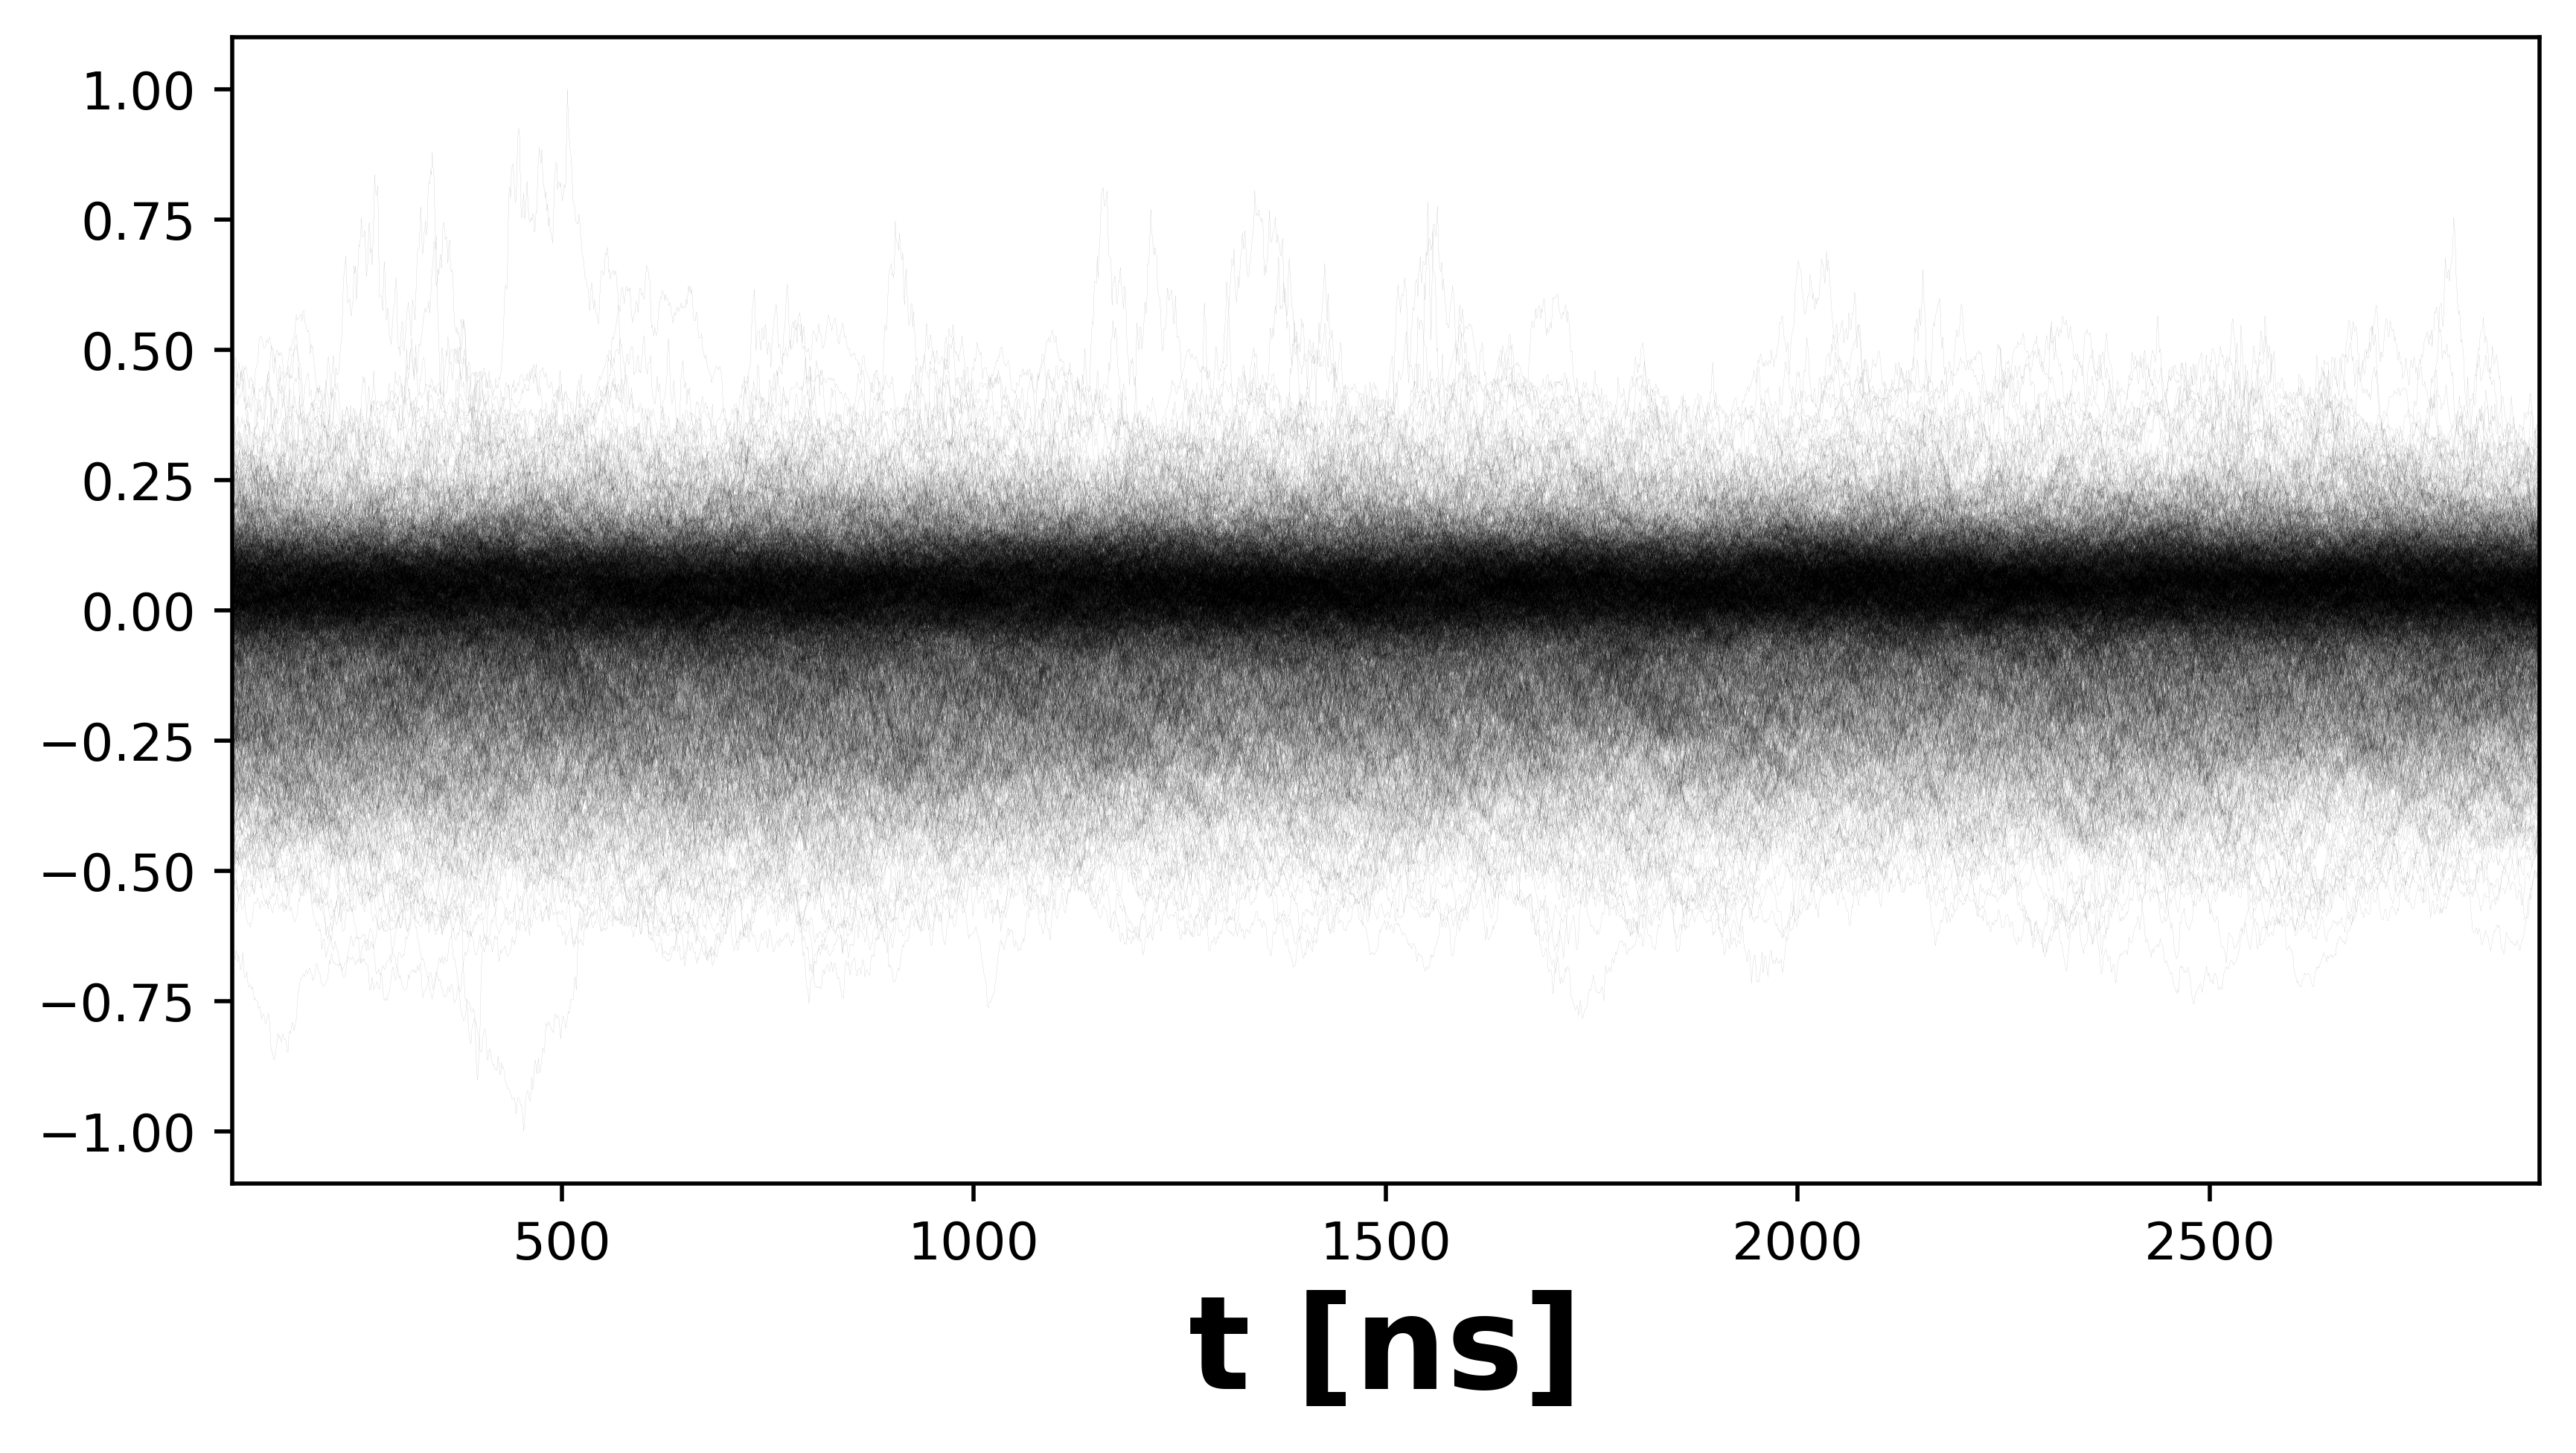

In [34]:
fig, axes = plt.subplots(
    1, figsize=(8, 4), dpi=500
)



for i in range(0, len(slope)):
    
    axes.plot(
        time,
        slope[i],
        color="black",
        linewidth=0.02,
        alpha=0.5,
    )
    
# axes.plot(
#         time,
#         slope[595],
#         color="magenta",
#         linewidth=1,
#         alpha=0.8,
#     )
    
    


axes.set_xlim(savGolPrint[0]+window_length // 2, savGolPrint[-1]+window_length // 2)
axes.set_xlabel(r't [ns]', weight = 'bold', size=25)
axes.set_xticks([500, 1500, 2500])
axes.set_xticklabels([0.5, 1.5, 2.5], fontsize=20)

axes.set_ylabel(r'χ', weight = 'bold', size=25)
axes.set_yticks([-1, -0.5, 0, 0.5, 1])
axes.set_yticklabels([-1, -0.5, 0, 0.5, 1], fontsize=20)
axes.set_ylim(-1, 1)
axes.axhline(y=slope_mean, color='magenta',linestyle='--', linewidth=3)



plt.subplots_adjust(wspace=0.08)
plt.savefig(XYZ_OUTDIR+'Figure/CHIparameter.png', bbox_inches='tight')

## 3.6 Time-Space Correlation Analysis

In [44]:
COFF_NNJOINT = 6

In [45]:
neigList = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=COFF_NNJOINT, trajSlice=windowToUSE)

In [46]:
neigList_tr = np.transpose(neigList)

/home/cristina/programs/SOAPify/latest_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [47]:
neigList_tr.shape

(2048, 2801)

In [48]:
# Remove the particle ITSELF from the neighbor list
for particle in range(0, neigList_tr.shape[0]):
    for frame in range(0, neigList_tr.shape[1]):
        index = np.where(neigList_tr[particle][frame] == particle)[0][0]
        neigList_tr[particle][frame] = np.delete(neigList_tr[particle][frame], index)

## LENS particle vs. tSOAP neig (and vice-versa)

In [ ]:
LEAP_val = []
LEAP_neig = []
tSOAP_neig = []
tSOAP_neig_MAX = []
tSOAP_val = []
LENS_neig = []
LENS_neig_MAX = []
LENS_val = []

for particle in range(0, tSOAP_rolling_norm.shape[0]):
    for frame in range(0, tSOAP_rolling_norm.shape[1]):
        
        LEAP_val.append(ts_LEAP[particle][frame])
        LENS_val.append(LENS_rolling_norm[particle][frame])
        tSOAP_val.append(tSOAP_rolling_norm[particle][frame])
    
        LEAP_neig_tmp = []
        tSOAP_neig_tmp = []
        LENS_neig_tmp = []
        for other_particle in neigList_tr[particle][frame]:
            
            LEAP_neig_tmp.append(ts_LEAP[other_particle][frame])
            tSOAP_neig_tmp.append(tSOAP_rolling_norm[other_particle][frame])
            LENS_neig_tmp.append(LENS_rolling_norm[other_particle][frame])
            
        
        LEAP_neig.append(np.mean(LEAP_neig_tmp))
        tSOAP_neig.append(np.mean(tSOAP_neig_tmp))
        tSOAP_neig_MAX.append(np.max(tSOAP_neig_tmp))
        LENS_neig.append(np.mean(LENS_neig_tmp))
        LENS_neig_MAX.append(np.max(LENS_neig_tmp))

In [171]:
tSOAP_val_arr = np.array(tSOAP_val)

In [172]:
LENS_val_arr = np.array(LENS_val)

In [173]:
tSOAP_neig_arr = np.array(tSOAP_neig)

In [174]:
LENS_neig_arr = np.array(LENS_neig)

In [ ]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)


# for i in range(0, len(LEAP_val)):
# ax.scatter(tSOAP_val, tSOAP_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

xy = [ [0]*2 for i in range(len(tSOAP_val))]
for i in range(0, len(tSOAP_val)):
    xy[i][0] = tSOAP_val[i]
    xy[i][1] = tSOAP_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
        
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel(r'<$\tau$SOAP$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  


plt.savefig(XYZ_OUTDIR+'Figure/tSOAP_tSOAPneig.png')

/tmp/ipykernel_837452/2966538281.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_837452/2966538281.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


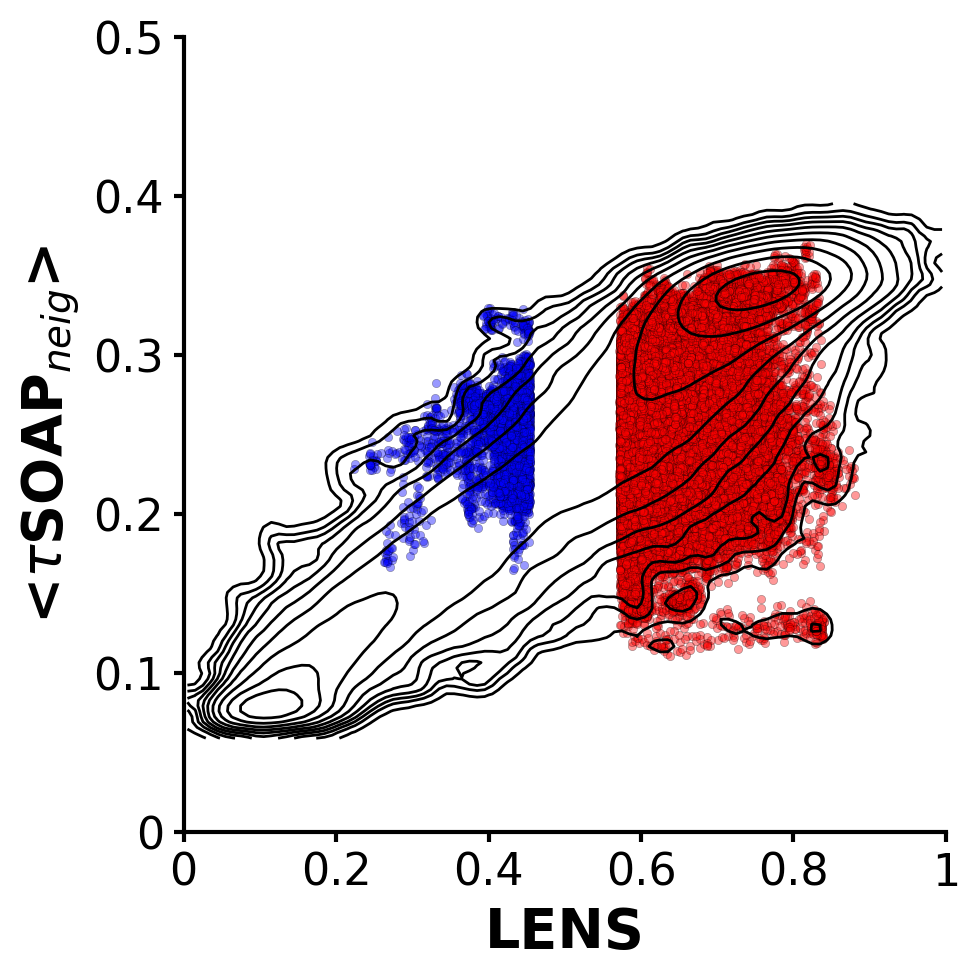

In [176]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(LENS_val, tSOAP_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(LENS_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)

tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(LENS_val_arr[tmp], tSOAP_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(LENS_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = LENS_val[i]
    xy[i][1] = tSOAP_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)

# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LENS_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
#     if tSOAP_val[i] > 0.7:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'LENS', weight='bold',size=20)
ax.set_ylabel(r'<$\tau$SOAP$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  

plt.savefig(XYZ_OUTDIR+'Figure/LENS_tSOAPneig.png')

/tmp/ipykernel_837452/173932682.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_837452/173932682.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


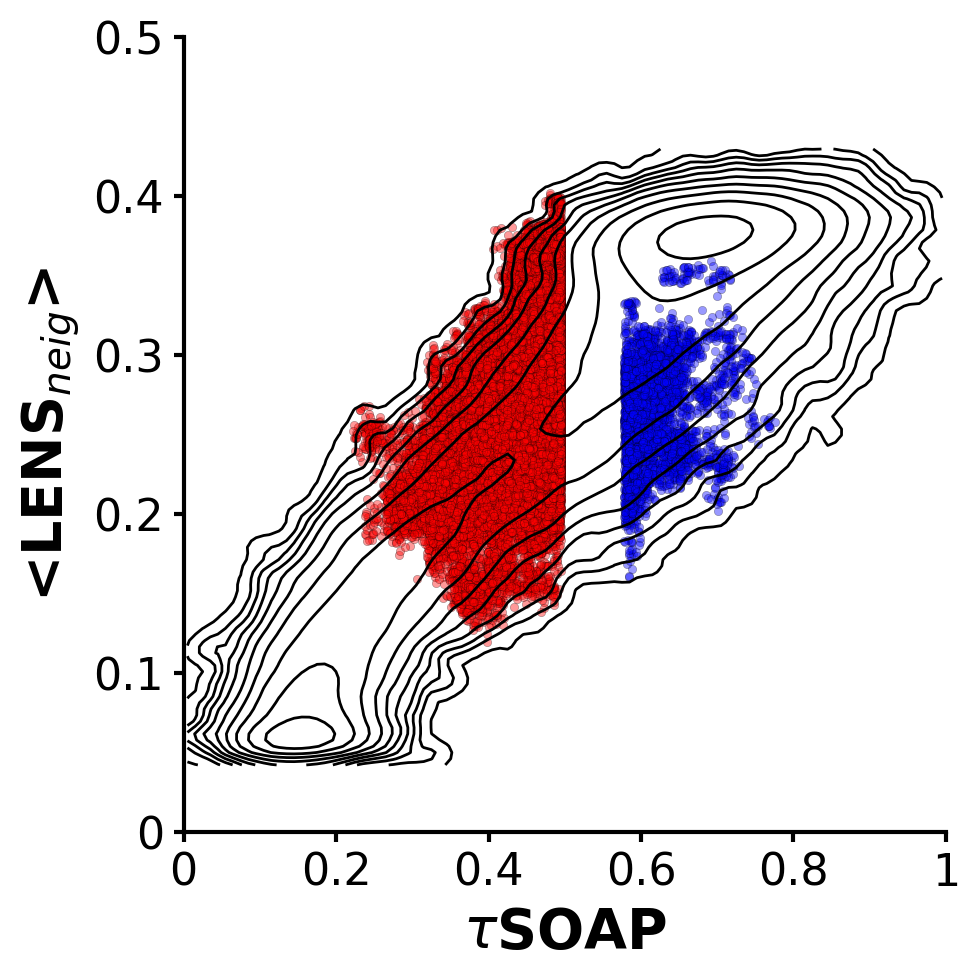

In [178]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(tSOAP_val, LENS_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(tSOAP_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)

tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(tSOAP_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(tSOAP_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = tSOAP_val[i]
    xy[i][1] = LENS_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LENS_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
#     if tSOAP_val[i] > 0.7:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'$\tau$SOAP', weight='bold',size=20)
ax.set_ylabel(r'<LENS$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
)  

plt.savefig(XYZ_OUTDIR+'Figure/tSOAP_LENSneig.png')

/tmp/ipykernel_837452/3281792328.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
/tmp/ipykernel_837452/3281792328.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


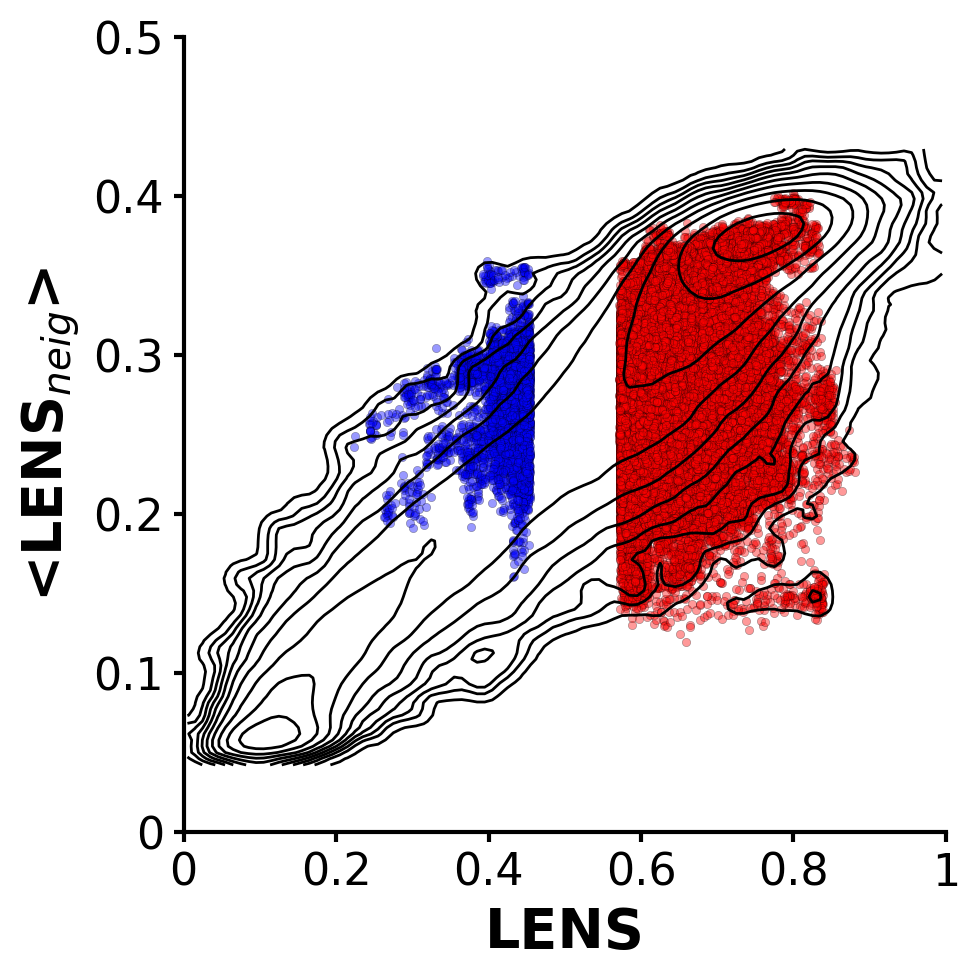

In [179]:
_, ax = plt.subplots(1, figsize=(5,5), dpi=200, tight_layout=True)

# for i in range(0, len(LEAP_val)):
# ax.scatter(LENS_val, LENS_neig, marker='.', color='thistle', edgecolors='black', linewidths=0.5, alpha=0.2)

tmp = np.where(np.logical_and(tSOAP_val_arr > Sup_thr_tSOAP, LENS_val_arr < Inf_thr_LENS))
ax.scatter(LENS_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='blue', edgecolors='black', linewidths=0.2, alpha=0.4)
tmp = np.where(np.logical_and(LENS_val_arr > Sup_thr_LENS, tSOAP_val_arr < Inf_thr_tSOAP))
ax.scatter(LENS_val_arr[tmp], LENS_neig_arr[tmp], marker='.', color='red', edgecolors='black', linewidths=0.2, alpha=0.4)

xy = [ [0]*2 for i in range(len(LENS_val))]
for i in range(0, len(LENS_val)):
    xy[i][0] = LENS_val[i]
    xy[i][1] = LENS_neig[i]
    
xy = np.array(xy)
lh, Xe, Ye, lhmin = getDensity(xy, 0, 1, 100)
levels = 10
cont = ax.contour(Xe,
    Ye,
    lh,
    colors="k",
    linewidths=1.0,
    levels=levels,
    antialiased=True,
    linestyles="solid",
    vmin=lhmin,
    vmax=0,
)
# for i in range(0, len(LENS_val)):
#     if LENS_val[i] > 0.5:
#         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='lime', edgecolors='black', linewidths=0.5, alpha=0.5)
# #     if tSOAP_val[i] > 0.7:
# #         ax.scatter(LEAP_val[i], tSOAP_neig[i], marker='.', color='red', edgecolors='black', linewidths=0.5, alpha=0.5)

        
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'LENS', weight='bold',size=20)
ax.set_ylabel(r'<LENS$_{neig}$>', weight='bold',size=20)


for side in ['right','top']:
    ax.spines[side].set_visible(False)
for side in ['bottom','right','top','left']:
    ax.spines[side].set_linewidth(1.5)
    
    
    
ax.tick_params(
axis='both',          # changes apply to the x-axis
which='major',      # both major and minor ticks are affected
bottom=True,
left=True,      
labelleft=True,
labelbottom=True,
width=1.5,
labelsize=16,
) 
plt.savefig(XYZ_OUTDIR+'Figure/LENS_LENSneig.png')